<a href="https://www.kaggle.com/code/kaizor11/statistical-modeling-with-tokyo-airbnb?scriptVersionId=219425000" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
*This notebook is the continuation of the [preprocessing step](https://www.kaggle.com/code/kaizor11/pre-processing-and-eda-with-tokyo-airbnb), where I cleaned and standardized values a Tokyo Airbnb dataset of over 10,000 entries.* 
In this notebook, I exprimented with various regression models to predict Airbnb prices using features such as `bedrooms`, `accommodates`, `rating`, and more.

Summary of notebook:
- Load in cleaned dataset from pre-processing step (no NaN, no outliers)
- Using a data-driven approach by traing the models with all features and allowing the models to select the most important ones
- Models tested: Linear Regression, Lasso CV, Regression Tree CV, Random Forest
- Models compared by their MSE
- Random Forest has the lowest MSE, and chosen to do predictions

Variables:
- `price`: in Japanese Yen, price per night of Airbnb
- `bedrooms`: number of bedrooms
- `accommodates`: number of accommodations (people)
- `rating`: rating of listing (out of 5)\
- `num_ratings`: number of reviews
- `neighborhood`: name of Tokyo neighborhood the listing is in
- `property_type`: categorical. Ex: "Entire rental unit", "Private room in home"
- `room_type`: categorical. Ex: "Private room", "Entire home/apt"
- `bathrooms`: categorical. Ex: "1.5 shared baths", "1 bath"

# Data load and pre-processing

In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/pre-processing-and-eda-with-tokyo-airbnb/tokyo_airbnb_no_outliers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10062 entries, 0 to 10061
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10062 non-null  int64  
 1   name           10062 non-null  object 
 2   neighborhood   10062 non-null  object 
 3   price          10062 non-null  int64  
 4   property_type  10062 non-null  object 
 5   room_type      10062 non-null  object 
 6   bathrooms      10062 non-null  object 
 7   bedrooms       10062 non-null  float64
 8   accommodates   10062 non-null  int64  
 9   num_reviews    10062 non-null  int64  
 10  rating         10062 non-null  float64
 11  longitude      10062 non-null  float64
 12  latitude       10062 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 1022.0+ KB


In [2]:
df.head()

,id,name,neighborhood,price,property_type,room_type,bathrooms,bedrooms,accommodates,num_reviews,rating,longitude,latitude
0,197677,Rental unit in Sumida,Sumida,11000,Entire rental unit,Entire home/apt,1 bath,1.0,2,173,4.78,139.826080,35.717070
1,776070,Home in Kita-ku,Kita,7208,Private room in home,Private room,1 shared bath,1.0,1,243,4.98,139.769170,35.738440
2,905944,Rental unit in Shibuya,Shibuya,23066,Entire rental unit,Entire home/apt,1 bath,2.0,6,186,4.76,139.678470,35.678780
3,1016831,Home in Setagaya,Setagaya,16000,Private room in home,Private room,1 shared bath,1.0,2,244,4.94,139.671340,35.658000
4,1196177,Home in 足立区,Adachi,10000,Private room in home,Private room,1.5 shared baths,1.0,4,95,4.71,139.797384,35.744731


# Regression Models
I will be training and evaluating four different models using the same train and test data: Linear Regression, Lasso CV, Decision Tree Regressor CV, and Random Forest

## Preparations
We first prepare the modeling process by:
- importing necessary libraries
- splitting data into traing and testing sets
- normalizing numeric features (for Linear Regression and Lasso)

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [4]:
seed = 42

### Train test split

In [5]:
# Features and Target
# X = df[['price', 'bedrooms', 'accommodates', 'num_reviews', 'rating', 'neighborhood']]
X = df.drop(columns=['id', 'name', 'longitude', 'latitude'])
X = X.drop(columns=['price'])
y = df['price']


X = pd.get_dummies(X, drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


### Data normalization
Scaling data for Linear Regression and Lasso

In [6]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
numeric_cols = X_train.select_dtypes(include=['number']).columns
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.fit_transform(X_test[numeric_cols])

## Baseline Model (for MSE comparison)
Simple baseline model using the mean of training data as the predictions. We will calculate the MSE from this model and use it as the baseline when comparing MSE from other models

In [7]:
# Calculate the mean of the target values in the training set
baseline_pred = np.full_like(y_test, y_train.mean())

# Calculate MSE for the baseline model
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline MSE: {baseline_mse}")

Baseline MSE: 94622859.869846


## Linear Regression
Using normalized training data

In [8]:
# Initialize and Fit the Model
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Predictions
y_pred = linreg.predict(X_test_scaled)

# Evaluation
lm_mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {lm_mse:.2f}')
# print(f"STD of Price: {sample['price'].std()}")

# Calculate percentage decrease in MSE compared to baseline
lm_percentage_decrease = ((baseline_mse - lm_mse) / baseline_mse) * 100
print(f"Decrease in MSE compared to baseline: {lm_percentage_decrease:.2f}%")

Mean Squared Error: 44804680.53
Decrease in MSE compared to baseline: 52.65%


## Lasso
Using normalized training data. Also using Cross Validation to find the optimal lambda for Lasso, then making predictions with the optimal Lasso model

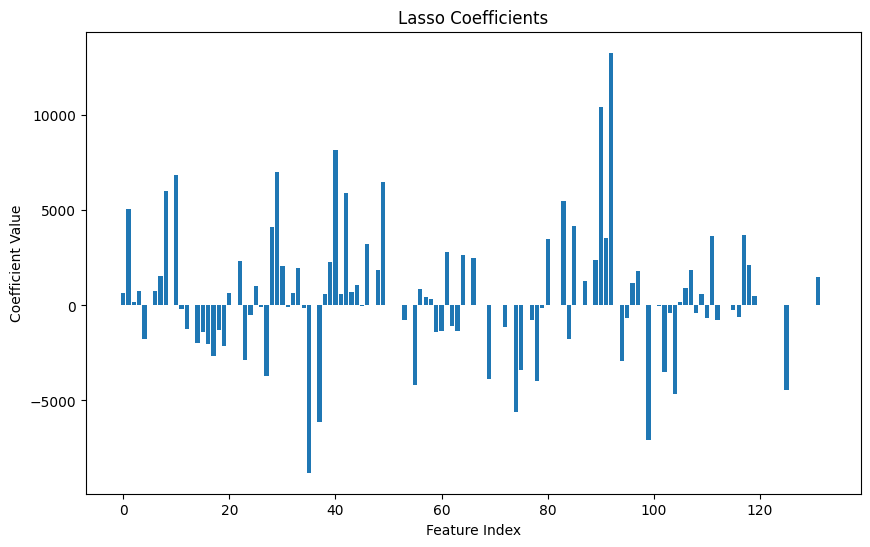

Optimal Lambda: 1.2742749857031335
Mean Squared Error: 44613549.54
Decrease in MSE compared to baseline: 52.85%


In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # to ignore non-convergence warnings

# We give the model a range of lambdas
lambdas = alphas = np.logspace(-2, 2, 20)

# Lasso Regression
lasso_cv = LassoCV(
    alphas=lambdas, 
    cv=5, 
    max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso_cv.coef_

# Plot to visualize the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients')
plt.show()

# Optimal lambda
print(f'Optimal Lambda: {lasso_cv.alpha_}')

# Prediction
y_pred = lasso_cv.predict(X_test_scaled)

# Compute the model score on the test set
lasso_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {lasso_mse:.2f}')

# Calculate percentage decrease in MSE compared to baseline
lasso_percentage_decrease = ((baseline_mse - lasso_mse) / baseline_mse) * 100
print(f"Decrease in MSE compared to baseline: {lasso_percentage_decrease:.2f}%")

## Decision Tree Regressor
Make predictions using a Decision Tree Regressor and using Cross Validation to improve prediction accuracy

In [10]:
# Build and train a decision tree model
tree = DecisionTreeRegressor(
    min_impurity_decrease=0.01,
    random_state=seed
    )
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {tree_mse}')

# Calculate percentage decrease in MSE compared to baseline
percentage_decrease = ((baseline_mse - tree_mse) / baseline_mse) * 100
print(f"Decrease in MSE compared to baseline: {percentage_decrease:.2f}%")

Mean Squared Error: 67829389.36384179
Decrease in MSE compared to baseline: 28.32%


In [11]:
# Increasing model accuracy using k-Fold CV
n_foldCV = 5
scores = cross_val_score(tree, X_train, y_train, cv=n_foldCV, scoring='neg_mean_squared_error')

mse_scores = -scores
print(f'Mean Squared Error (CV): {mse_scores.mean()}')

# Calculate percentage decrease in MSE compared to baseline
tree_percentage_decrease = ((baseline_mse - mse_scores.mean()) / baseline_mse) * 100
print(f"Decrease in MSE compared to baseline: {tree_percentage_decrease:.2f}%")

Mean Squared Error (CV): 63941341.365493536
Decrease in MSE compared to baseline: 32.43%


## Random Forest

In [12]:
# Random forest model
forest = RandomForestRegressor(random_state=seed)
forest.fit(X_train, y_train)

# Predictions
y_pred = forest.predict(X_test)

# MSE Calculation
rf_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {rf_mse}')

# Calculate percentage decrease in MSE compared to baseline
rf_percentage_decrease = ((baseline_mse - rf_mse) / baseline_mse) * 100
print(f"Decrease in MSE compared to baseline: {rf_percentage_decrease:.2f}%")

Mean Squared Error: 38746112.5101888
Decrease in MSE compared to baseline: 59.05%
0.4232858884084927


# Model Comparison
We compare the MSE from each model and their respective percentage decrease when comparing to the baseline model. We can see that our Random Forest Model gave us the least MSE, so we will using that to make predictions

In [13]:
print(f"Linear Regression \nMSE: {lm_mse} \nPercentage Decrease: {lm_percentage_decrease} \n")
print(f"Lasso CV \nMSE: {lasso_mse} \nPercentage Decrease: {lasso_percentage_decrease} \n")
print(f"Tree Regressor CV \nMSE: {tree_mse} \nPercentage Decrease: {tree_percentage_decrease} \n")
print(f"Random Forest \nMSE: {rf_mse} \nPercentage Decrease: {rf_percentage_decrease} \n")

Linear Regression 
MSE: 44804680.53015074 
Percentage Decrease: 52.64920063525908 

Lasso CV 
MSE: 44613549.53941517 
Percentage Decrease: 52.85119304068675 

Tree Regressor CV 
MSE: 67829389.36384179 
Percentage Decrease: 32.42505938475647 

Random Forest 
MSE: 38746112.5101888 
Percentage Decrease: 59.05205934011698 



In [14]:
print(f"Linear Regression RMSE: {np.sqrt(lm_mse)}")
print(f"Lasso CV RMSE: {np.sqrt(lasso_mse)}")
print(f"Tree Regressor CV RMSE: {np.sqrt(tree_mse)}")
print(f"Random Forest RMSE: {np.sqrt(rf_mse)}")

Linear Regression RMSE: 6693.629847112159
Lasso CV RMSE: 6679.337507523869
Tree Regressor CV RMSE: 8235.859965045653
Random Forest RMSE: 6224.637540466819


In [15]:
print(f"Price STD: {df['price'].std()}")
print(f"Avg Airbnb Price: {df['price'].mean()}")

Price STD: 9567.946858976777
Avg Airbnb Price: 16096.464619359967


Random Forest has:
- Relative RMSE (RMSE / STD): `6224.64/9567.95` = `0.65` which means the model does moderate job at capturing the variability in the data
- Relative Error (RMSE / Avg Price): `6224.64/16096.46` = `0.387` which is pretty high for the average price. This can likely be due to the high variability in the dataset. A fix in the future may be to split the data into budget and luxury listings to reduce price variability